Some ideas:

Use only a small amount of coefficients within a sphere to approximate the image.

Once we have a rough approximation of the image, we get the set of candidates for the reconstruction by selecting the coefficients which had low power and which are within the missing wedge.

The neighbors of point x0 that will be used for the reconstruction are the ones with very high power and which lie within a shell that includes x0.

In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup

import numpy as np
import matplotlib.pyplot as plt
import random
import mrcfile
import pandas as pd
import torch
import os
from glob import glob
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_mutual_information as nmi
from scipy import ndimage

PARENT_PATH = setup.PARENT_PATH
ISONET_PATH = os.path.join(PARENT_PATH, 'data/isoNet/')

def clip_and_standardize(X, low=0.005, high=0.995, quantiles=True):
    if quantiles:
        X_clp = np.clip(X, np.quantile(X, low), np.quantile(X, high))
    else:
        X_clp = np.clip(X, low, high)
    X_stdz = (X_clp-np.mean(X_clp))/np.std(X_clp)
    
    return X_stdz

def plot_image_and_spectrum(cet, logPower, z0, y0, x0):
    
    fig, ax = plt.subplots(3, 2, figsize=(20, 13), gridspec_kw={'height_ratios': [2, 1, 1]})  
    plt.tight_layout()
    ax[0][0].imshow(cet[z0])
    ax[0][0].set_title('Image XY')

    ax[0][1].imshow(logPower[z0])
    ax[0][1].set_title('Corresponding Power Spectrum')

    ax[1][0].imshow(cet[:, y0, :])
    ax[1][0].set_title('Image ZX')

    ax[1][1].imshow(logPower[:, y0, :])
    ax[1][1].set_title('Corresponding Power Spectrum')

    ax[2][0].imshow(cet[:, :, x0])
    ax[2][0].set_title('Image ZY')

    ax[2][1].imshow(logPower[:, :, x0])
    ax[2][1].set_title('Corresponding Power Spectrum')

    plt.show()
    
    return

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
def make_3Dshell(inner_radius, delta_r, tomo_shape):

    outer_radius = inner_radius+delta_r

    length = min(tomo_shape)
    mask_shape = 3*[length]
    _shell_mask = np.zeros(mask_shape)

    # only do positive quadrant first
    for z in range(0, outer_radius+1):
        for y in range(0, outer_radius+1):
            for x in range(0, outer_radius+1):
                
                r = np.linalg.norm([y, x, z])

                if r>=inner_radius and r<=outer_radius:

                    zidx = z + length//2
                    yidx = y + length//2
                    xidx = x + length//2

                    _shell_mask[zidx, yidx, xidx] = 1

    # first get shell for x>0
    aux = np.rot90(_shell_mask, axes=(0, 1)) + np.rot90(_shell_mask, 2, axes=(0, 1)) + np.rot90(_shell_mask, 3, axes=(0, 1))
    aux2 = _shell_mask + aux 

    # now reflect the shell along x to get the full shell
    aux2 += np.rot90(aux2, 2, axes=(1, 2))

    # finally, fill the actual shape of the tomogram with the mask
    shell_mask = np.zeros(tomo_shape)
    shell_mask[(tomo_shape[0] - length)//2:(tomo_shape[0] + length)//2,
                (tomo_shape[1] - length)//2:(tomo_shape[1] + length)//2,
                (tomo_shape[2] - length)//2:(tomo_shape[2] + length)//2] = aux2
    
    return shell_mask

# Spinach cells

In [3]:
# cet = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo32.mrc')
cet_path = os.path.join(ISONET_PATH, 'RAW_dataset/RAW_allTomos_deconv/tomo10.mrc')
cet = clip_and_standardize(read_array(cet_path))

tomo_shape = cet.shape

print(tomo_shape)

(464, 928, 928)


In [4]:
fft_cet = np.fft.fftshift(np.fft.fftn(cet))
logPower_cet = np.log(np.abs(fft_cet)**2)
logPower_cet = clip_and_standardize(logPower_cet, low=0.001, high=0.999)

## Make 3D shell

In [28]:
shell_mask = make_3Dshell(10, 10, tomo_shape)

power_mask = (logPower_cet>3).astype(int)

logPower_masked = logPower_cet*shell_mask*power_mask

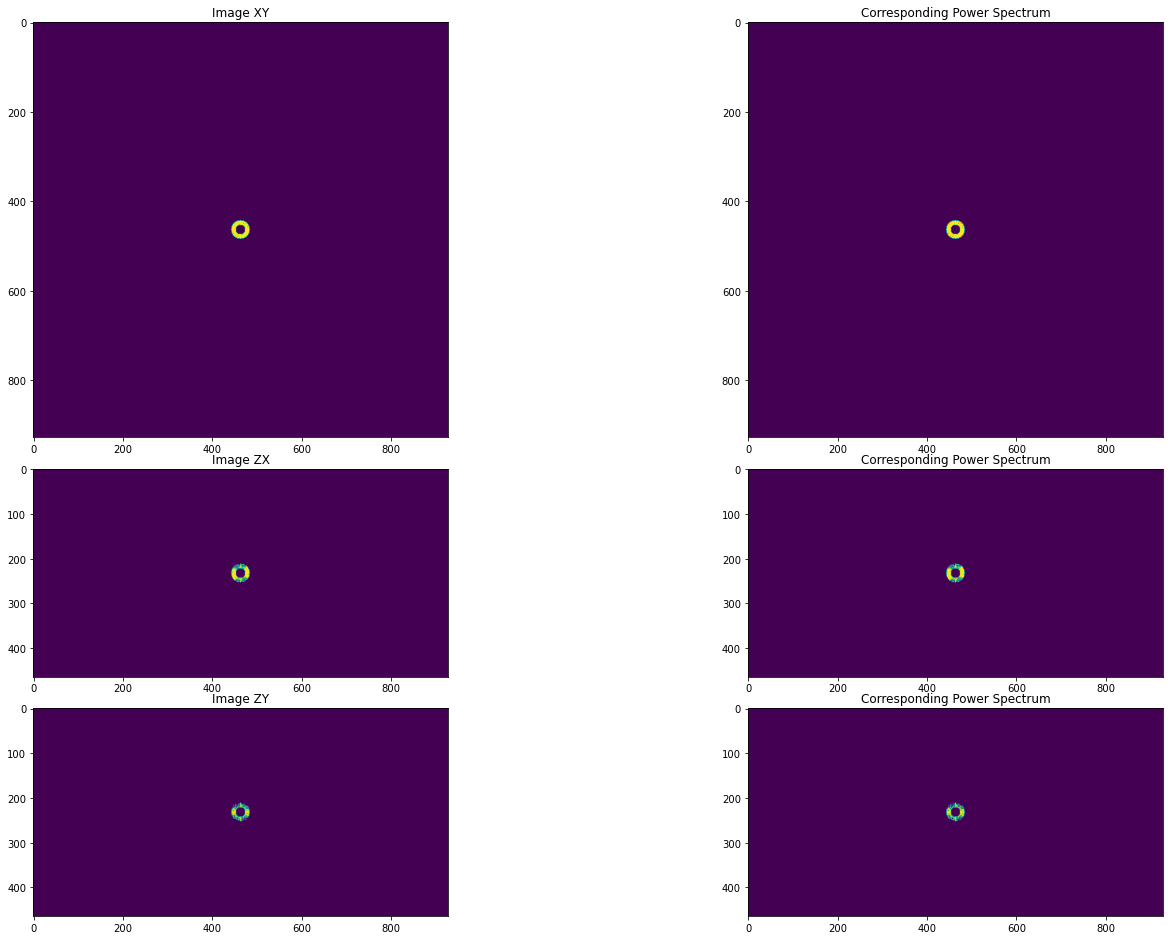

In [29]:
z0, y0, x0 = [s//2 for s in tomo_shape]
plot_image_and_spectrum(logPower_masked, logPower_masked, z0, y0, x0)

In [21]:
fft_masked = fft_cet*shell_mask*power_mask
cet_masked = np.fft.ifftn(np.fft.ifftshift(fft_masked))
cet_masked = np.real(cet_masked)

logPower_masked = logPower_cet*shell_mask*power_mask
# fft_masked = np.fft.fftshift(np.fft.fftn(cet_masked))
# logPower_masked = np.log(np.abs(fft_masked)**2)
# logPower_masked = clip_and_standardize(logPower_masked, low=0.001, high=0.999)

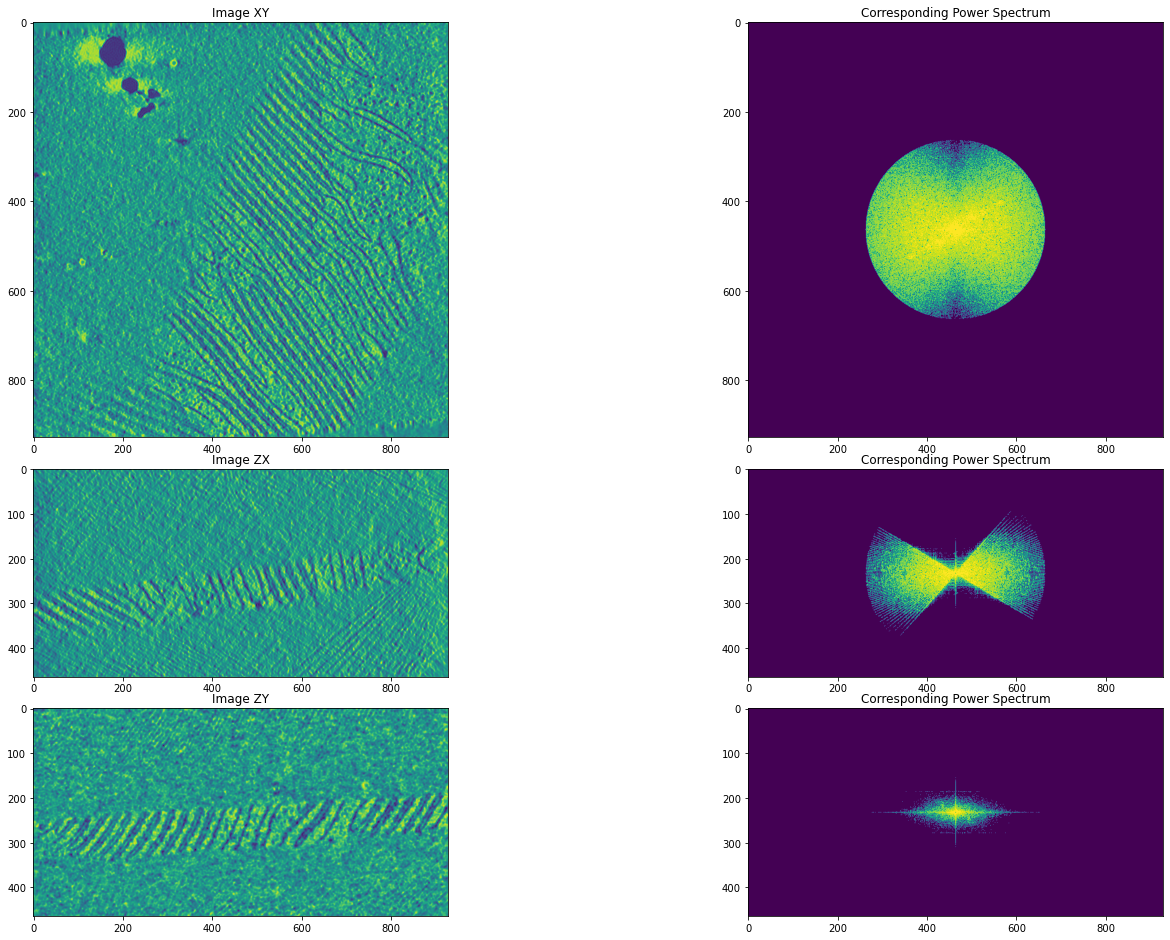

In [22]:
z0, y0, x0 = [s//2 for s in tomo_shape]
plot_image_and_spectrum(cet_masked, logPower_masked, z0, y0, x0)

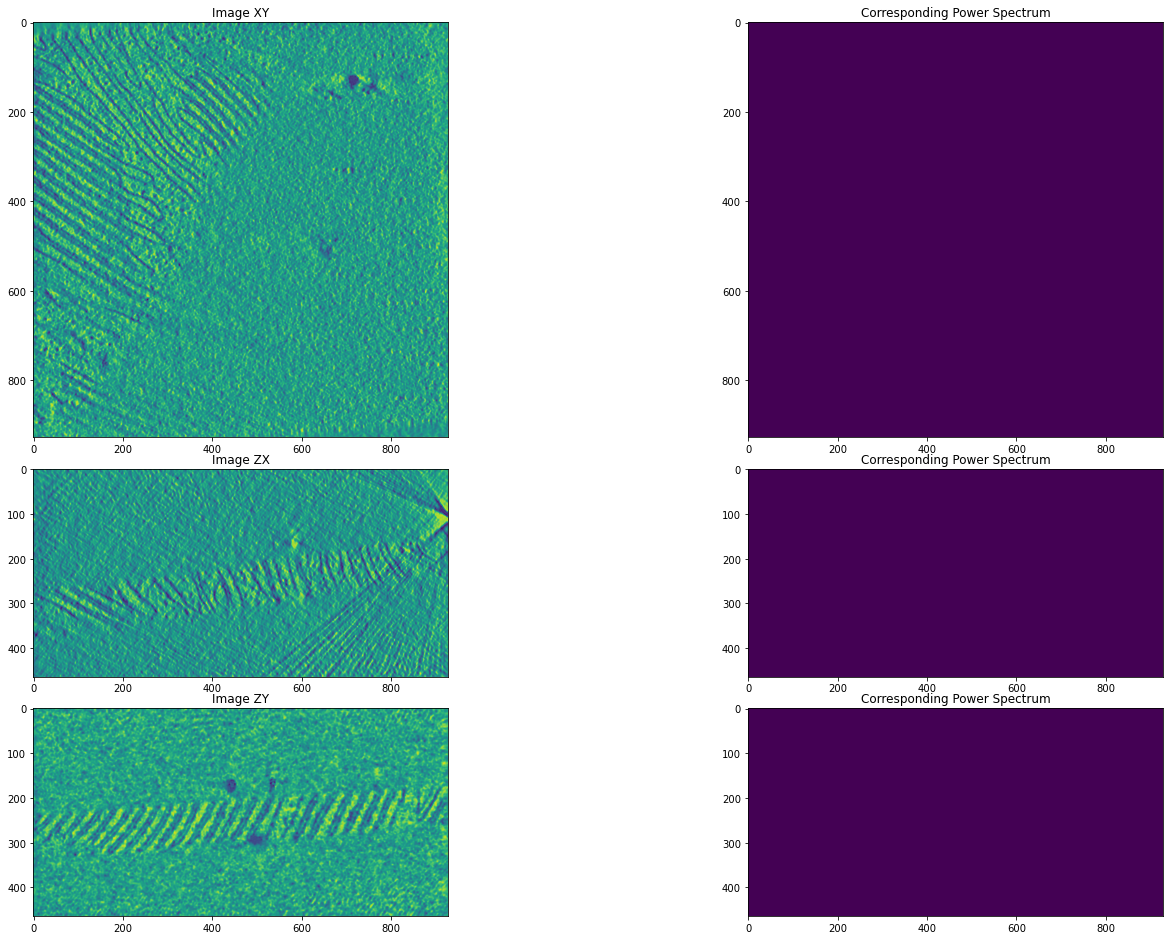

In [30]:
z0, y0, x0 = [s//2 + 100 for s in tomo_shape]
plot_image_and_spectrum(cet_masked, logPower_masked, z0, y0, x0)

In [24]:
# a ball of r=150 yields ssim = 0.8486415205220202
# r=200 => ssim = 0.9577
# r=200 & logPower>3 => ssim = 0.9444
ssim(cet, cet_masked)

0.944438014627865

In [1]:
plt.hist(logPower_masked[logPower_masked!=0].flatten())

NameError: name 'plt' is not defined

## Chose missing values within missing wedge

The way we are going to label values as missing depends on two conditions:

1. They have "low" frequencies
2. They fall within the missing wedge region

In [ ]:
for z in range(0, tomo_shape[0]//2):
    for xidx, x in enumerate(range(-tomo_shape[2]//2, tomo_shape[2]//2)):
        r = np.linalg.norm([z, x])
        
        phi = np.arctan2(z, x)
        phi = (2*np.pi+phi)%(2*np.pi)

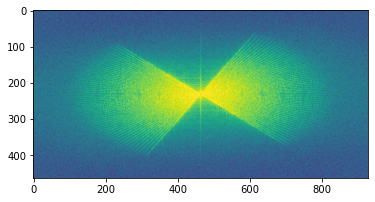

In [7]:
plt.imshow(logPower_cet[:, tomo_shape[1]//2, :])